# Übung 2.9 Todesursachen
Wie bereits in anderen Übungen besprochen, muss man zuerst wieder die Daten in das HDFS laden. Dazu habe ich wieder die Datei `death2016.csv` in das Volume des `namenode` Containers hineinkopiert, ich bin in das dazugehörende Verzeichnis in dem `namenode` Container hineingegangen mittels `docker exec -it namenode bash` und `cd /hadoop-data`, und schließlich habe ich die Daten in das HDFS mittels `hadoop fs -copyFromLocal death2016.csv workspace/pyspark` kopiert. 

## Initialisierung der Spark Session

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql import dataframe
from pyspark.sql.functions import to_timestamp, to_date, year, dayofweek, col, expr, lower, col
from IPython.display import display

In [2]:
# Spark session & context
spark = SparkSession \
    .builder \
    .master('spark://spark-master:7077') \
    .appName("uebung_29") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

## Einlesen der deaths-Datei

In [3]:
# Define schema of death file
death_cols = [
    StructField('country', StringType()),
    StructField('cause_no', IntegerType()),
    StructField('cause_name', StringType()),
    StructField('sex', StringType()),
    StructField('age', IntegerType()),
    StructField('age_group', StringType()),
]

for year in range(2000, 2017):
    death_low_up = [StructField(f'deaths_{year}', FloatType()),
                    StructField(f'low_{year}', FloatType()),
                    StructField(f'up_{year}', FloatType())]
    death_cols += death_low_up
    
death_schema = StructType(death_cols)
print(death_schema.fieldNames())

['country', 'cause_no', 'cause_name', 'sex', 'age', 'age_group', 'deaths_2000', 'low_2000', 'up_2000', 'deaths_2001', 'low_2001', 'up_2001', 'deaths_2002', 'low_2002', 'up_2002', 'deaths_2003', 'low_2003', 'up_2003', 'deaths_2004', 'low_2004', 'up_2004', 'deaths_2005', 'low_2005', 'up_2005', 'deaths_2006', 'low_2006', 'up_2006', 'deaths_2007', 'low_2007', 'up_2007', 'deaths_2008', 'low_2008', 'up_2008', 'deaths_2009', 'low_2009', 'up_2009', 'deaths_2010', 'low_2010', 'up_2010', 'deaths_2011', 'low_2011', 'up_2011', 'deaths_2012', 'low_2012', 'up_2012', 'deaths_2013', 'low_2013', 'up_2013', 'deaths_2014', 'low_2014', 'up_2014', 'deaths_2015', 'low_2015', 'up_2015', 'deaths_2016', 'low_2016', 'up_2016']


In [4]:
# Read in death file with pre-defined schema
file_path = 'hdfs://namenode:8020/user/root/workspace/pyspark/death2016.csv'
deaths = spark.read.csv(file_path, death_schema)
print(deaths.printSchema())
print(deaths.show(1))

root
 |-- country: string (nullable = true)
 |-- cause_no: integer (nullable = true)
 |-- cause_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- deaths_2000: float (nullable = true)
 |-- low_2000: float (nullable = true)
 |-- up_2000: float (nullable = true)
 |-- deaths_2001: float (nullable = true)
 |-- low_2001: float (nullable = true)
 |-- up_2001: float (nullable = true)
 |-- deaths_2002: float (nullable = true)
 |-- low_2002: float (nullable = true)
 |-- up_2002: float (nullable = true)
 |-- deaths_2003: float (nullable = true)
 |-- low_2003: float (nullable = true)
 |-- up_2003: float (nullable = true)
 |-- deaths_2004: float (nullable = true)
 |-- low_2004: float (nullable = true)
 |-- up_2004: float (nullable = true)
 |-- deaths_2005: float (nullable = true)
 |-- low_2005: float (nullable = true)
 |-- up_2005: float (nullable = true)
 |-- deaths_2006: float (nullable = true)
 |-- 

## Teilaufgabe 1
Todesursache mit Anzahl an Todesfällen

In [5]:
# Creating a temporary view so that we can execute SparkQL statements
deaths.createOrReplaceTempView('deaths')

In [6]:
# Function that returns column names of certain death numbers for all years
def get_death_cols(col='deaths'):
    return [f'{col}_{year}' for year in range(2000, 2017)]

get_death_cols()

['deaths_2000',
 'deaths_2001',
 'deaths_2002',
 'deaths_2003',
 'deaths_2004',
 'deaths_2005',
 'deaths_2006',
 'deaths_2007',
 'deaths_2008',
 'deaths_2009',
 'deaths_2010',
 'deaths_2011',
 'deaths_2012',
 'deaths_2013',
 'deaths_2014',
 'deaths_2015',
 'deaths_2016']

In [26]:
# Function that creates an summation expression of all death columns
def get_death_expr(col='deaths', operator='+'):
    death_cols = get_death_cols(col)
    expr = f' {operator} '.join(death_cols)
    return expr

get_death_expr()

'deaths_2000 + deaths_2001 + deaths_2002 + deaths_2003 + deaths_2004 + deaths_2005 + deaths_2006 + deaths_2007 + deaths_2008 + deaths_2009 + deaths_2010 + deaths_2011 + deaths_2012 + deaths_2013 + deaths_2014 + deaths_2015 + deaths_2016'

In [27]:
# Create an SparkQL statement with the death columns
death_cols_str = get_death_expr()
stmt = (f'select cause_name, sum({death_cols_str}) as total '
       'from deaths where country = "DEU" '
        'group by cause_name '
       'order by total desc;')
print('SparkQL statement:', stmt)

# Execute the SparkQL statement
death_cause_ger = spark.sql(stmt)
death_cause_ger.show()

SparkQL statement: select cause_name, sum(deaths_2000 + deaths_2001 + deaths_2002 + deaths_2003 + deaths_2004 + deaths_2005 + deaths_2006 + deaths_2007 + deaths_2008 + deaths_2009 + deaths_2010 + deaths_2011 + deaths_2012 + deaths_2013 + deaths_2014 + deaths_2015 + deaths_2016) as total from deaths where country = "DEU" group by cause_name order by total desc;
+--------------------+--------------------+
|          cause_name|               total|
+--------------------+--------------------+
|          All Causes|1.4551129185058594E7|
|Noncommunicable d...|1.3325673312011719E7|
|Cardiovascular di...|    6070731.26240921|
| Malignant neoplasms|   3786898.846229553|
|Ischaemic heart d...|   3556194.562406063|
|              Stroke|  1135246.9709677696|
|Other circulatory...|   888717.4789266586|
|Respiratory diseases|   875449.3753051758|
|Trachea; bronchus...|    738239.602329731|
|  Digestive diseases|   737520.3945465088|
|Chronic obstructi...|   711904.0276870728|
|    Ischaemic stroke

## Teilaufgabe 2
Todesursache mit Anzahl Todesfällen im Jahr 2016 absteigend sortiert nach Todesursache.

Ich gehe davon aus, dass wiederum die Anzahl Todesfälle in Deutschland gemeint sind. Außerdem scheint es mir sinnvoll nach der Anzahl an Todesfällen zu sortieren, anstatt nach dem Namen der Todesursache.

In [8]:
# Filtering for all rows in Germany
deaths_de = deaths.filter(deaths['country'] == 'DEU')

# Filtering for all deaths in 2016
deaths_de = deaths_de.filter(deaths['deaths_2016'] > 0)

# Selecting all relevant columns
deaths_de = deaths_de.select('cause_name', 'deaths_2016')

# Group by death cause
deaths_de = deaths_de.groupBy('cause_name')

# Summing up all deaths per death cause
deaths_de = deaths_de.sum('deaths_2016')

# Rename summed up column
deaths_de = deaths_de.withColumnRenamed('sum(deaths_2016)', 'deaths_2016')

# Sort by sum of deaths
deaths_de = deaths_de.orderBy('deaths_2016', ascending=False)
deaths_de = deaths_de.show()

+--------------------+------------------+
|          cause_name|       deaths_2016|
+--------------------+------------------+
|          All Causes| 920556.6735839844|
|Noncommunicable d...| 839535.8052215576|
|Cardiovascular di...|343530.82811903954|
| Malignant neoplasms|235379.45161151886|
|Ischaemic heart d...|  191912.831159126|
|Neurological cond...| 72568.20000190288|
|Other circulatory...| 59006.17331010103|
|Respiratory diseases|58838.875165462494|
|              Stroke|58306.235140547156|
|Alzheimer disease...| 48769.67004454136|
|Chronic obstructi...|48208.593697309494|
|Trachea; bronchus...|47131.487330913544|
|Communicable; mat...| 44314.14274406433|
|  Digestive diseases| 40566.07289594412|
|            Injuries| 36706.71230316162|
|    Ischaemic stroke| 35402.90802706033|
|Genitourinary dis...|29864.502741485834|
|Colon and rectum ...|28808.684104919434|
|Unintentional inj...|24941.597425460815|
|   Diabetes mellitus|24763.661523155868|
+--------------------+------------

## Teilaufgabe 3
Erstellen Sie folgende Grafik bezogen auf die Todesursache 0 (Gesamtfälle).

Die Grafik bezieht sich auf Deutschland, also werde ich wie vorher die Ergebnismenge auf Deutschland einschränken. Folgende Erklärungen zu den Spaltennamen:

- Die `deahts_<year>` Spalten sind die Spalten, die tatsächlichen Todesfälle beinhalten
- Die `up_<year>` Spalten sind die Spalten, die die maximale Schätzung an Todesfällen beinhalten
- Die `low_<year>` Spalten sind die Spalten, die die minimale Schätzung an Todesfällen beinhalten

In [9]:
# Create a function that extracts the year string from the colum name
# In this exercise all consecutive integers are assumed to constitute a year
def extract_year(col_name):
    year = ''
    for char in col_name:
        if char.isdigit():
            year += char
    return year

In [10]:
extract_year('sum(up_2016)')

'2016'

In [11]:
# Create a function that returns a dataframe with one row and one column for every year
def get_death_df(deaths, death_type):
    # Validate parameters
    if death_type not in ['up', 'low', 'deaths']:
        raise ValueError('death_type must be one of "up", "low", or "deaths"')
    print('death_type:', death_type)
    
    # Filter for the relevant rows
    deaths_de_0 = deaths.filter(deaths['country'] == 'DEU').filter(deaths['cause_no'] == 0)

    # Create a dataframe with one row where each column contains the death data 
    # for particular year
    cols = get_death_cols(death_type)
    deaths_de_0 = deaths_de_0.groupBy('cause_no').sum(*cols).drop('cause_no', *cols)
    
    # Make sure we have exactly one row per death cause, i.e. cause_no == 0
    assert deaths_de_0.count() == 1
    
    # Now the data is small enough to convert it to a pandas dataframe 
    # (which is read into memory of the driver, i.e. this notebook)
    deaths_df = deaths_de_0.toPandas()
    
    # Rename all columns, so that each plot has the same x-axis later
    for col in deaths_df.columns:
        year = extract_year(col)
        if year:
            deaths_df = deaths_df.rename(columns={col: year})
            
    # Print the dataframe just for debugging
    display(deaths_df.head())
    
    return deaths_df

death_type: up


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,843813.866302,833598.14032,846751.093079,858939.595093,823146.416809,835246.873291,826624.910645,832002.4021,849529.402679,859621.054047,863828.828613,857820.393341,875914.61615,900959.268066,875921.288635,933929.358765,928803.817902


death_type: deaths


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,838848.592865,828558.538605,841765.283539,853992.677307,818314.885925,830357.249451,821844.718262,827206.096863,844688.994873,854816.832825,859005.383911,852524.178467,870017.796112,894285.81311,868734.533615,925610.80069,920556.673584


death_type: low


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,833825.616425,823622.689972,836808.017761,849016.656952,813491.437683,825499.812469,817042.248047,822419.843994,839881.529602,849938.210785,854148.235901,847215.332611,864075.717316,887644.153168,861489.567764,917286.926376,912305.019073


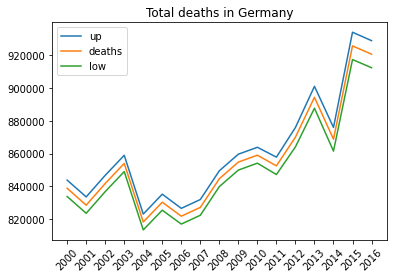

In [12]:
# Plot the upper estimated (up), actual (deaths) and lower estimated (low) deaths in one single plot
fig, ax = plt.subplots()
for death_type in ['up', 'deaths', 'low']:
    death_df = get_death_df(deaths, death_type)
    ax.plot(death_df.columns, death_df.values.ravel(), label=death_type)
plt.title('Total deaths in Germany')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Teilaufgabe 4
Erstellen Sie eine Auswertung gruppiert nach der Todesursache und aggregiert nach der Anzahl an Todesfällen für das Jahr 2016.

Für diese Aufgabe werde ich die *tatsächlichen* Todeszahlen von Deutschland heranziehen und mich bei der Darstellung der Ergebnisse auf die 10 häufigsten Todesursachen beschränken.

In [13]:
# Calculate the sum of deaths in 2016 by death cause_name
deaths_2016 = deaths.filter(deaths['country'] == 'DEU').filter(deaths['deaths_2016'] > 0)
deaths_2016 = deaths_2016.groupBy('cause_name') \
    .sum('deaths_2016') \
    .withColumnRenamed('sum(deaths_2016)', 'sum_deaths_2016') \
    .orderBy('sum_deaths_2016', ascending=False) \
    .limit(10)
deaths_2016.show()

+--------------------+------------------+
|          cause_name|   sum_deaths_2016|
+--------------------+------------------+
|          All Causes| 920556.6735839844|
|Noncommunicable d...| 839535.8052215576|
|Cardiovascular di...|343530.82811903954|
| Malignant neoplasms|235379.45161151886|
|Ischaemic heart d...|  191912.831159126|
|Neurological cond...| 72568.20000190288|
|Other circulatory...| 59006.17331010103|
|Respiratory diseases|58838.875165462494|
|              Stroke|58306.235140547156|
|Alzheimer disease...| 48769.67004454136|
+--------------------+------------------+



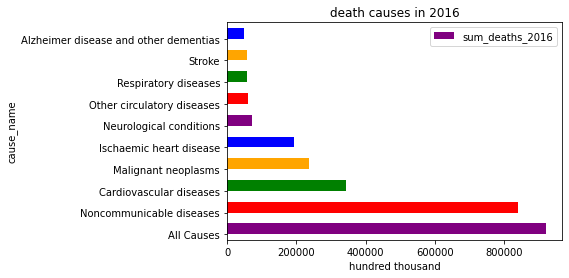

In [14]:
# Create a bar plot of all death causes
deaths_2016_df = deaths_2016.toPandas()
ax = deaths_2016_df.plot.barh(x='cause_name', 
                         y='sum_deaths_2016',
                        align='edge',
                        color=['purple', 'red', 'green', 'orange', 'blue'])
_ = ax.set_xlabel('hundred thousand')
_ = ax.set_title('death causes in 2016')

## Teilaufgabe 5
Erstellen Sie einen zeitlichen Vergleich der Anzahl an Todesfällen bezogen auf eine Todesursache (in der Abbildung bezogen auf die Todesursache 0.

Zuerst, werde ich die prozentualen Änderungen von Jahr zu Jahr plotten und wie in der Vorlesung werde ich mich auf Todesfälle in Deutschland beschränken. Danach werde ich zus#tzlich die prozentualen Änderungen im Vergleich zum Jahr 2000 plotten.

In [15]:
# Calculate the sum of all deaths for death cause_no 0
death_cols = get_death_cols()
deaths_0 = deaths.filter(deaths['cause_no'] == 0) \
    .filter(deaths['country'] == 'DEU') \
    .groupBy('cause_no') \
    .sum(*death_cols)
deaths_0.show()

+--------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|cause_no| sum(deaths_2000)| sum(deaths_2001)| sum(deaths_2002)| sum(deaths_2003)|sum(deaths_2004)| sum(deaths_2005)| sum(deaths_2006)|sum(deaths_2007)| sum(deaths_2008)|sum(deaths_2009)| sum(deaths_2010)| sum(deaths_2011)| sum(deaths_2012)| sum(deaths_2013)| sum(deaths_2014)| sum(deaths_2015)| sum(deaths_2016)|
+--------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       0|838848.5928649902|828558.5386047363|841765.28353

In [16]:
# Rename the columns
deaths_0_df = deaths_0.toPandas()
for col in deaths_0_df.columns:
    year = extract_year(col)
    if year:
        deaths_0_df = deaths_0_df.rename(columns={col: year})
deaths_0_df = deaths_0_df.drop('cause_no', axis=1)
deaths_0_df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,838848.592865,828558.538605,841765.283539,853992.677307,818314.885925,830357.249451,821844.718262,827206.096863,844688.994873,854816.832825,859005.383911,852524.178467,870017.796112,894285.81311,868734.533615,925610.80069,920556.673584


In [17]:
# Transpose the above dataframe
deaths_long = deaths_0_df.melt(value_vars=deaths_0_df.columns,
                              var_name='year',
                              value_name='deaths_this_year')
display(deaths_long.head())

,year,deaths_this_year
0,2000,838848.592865
1,2001,828558.538605
2,2002,841765.283539
3,2003,853992.677307
4,2004,818314.885925


In [18]:
# Calculate percentage differences between years
deaths_long['deaths_last_year'] = deaths_long.shift(1)['deaths_this_year']
deaths_long['diff_year_to_year'] = ((deaths_long['deaths_this_year'] - deaths_long['deaths_last_year']) / 
                                    deaths_long['deaths_last_year'])
deaths_long.head()

,year,deaths_this_year,deaths_last_year,diff_year_to_year
0,2000,838848.592865,NaN,NaN
1,2001,828558.538605,838848.592865,-0.012267
2,2002,841765.283539,828558.538605,0.015939
3,2003,853992.677307,841765.283539,0.014526
4,2004,818314.885925,853992.677307,-0.041778


<AxesSubplot:xlabel='year'>

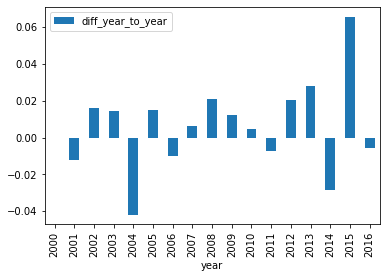

In [19]:
# Plot the percentage differences as bar plots
deaths_long.plot.bar(x='year', y='diff_year_to_year')

In [20]:
# Calculate the percentage differences with respect to year 2000
deaths_2000 = deaths_long.loc[deaths_long.year == '2000', 'deaths_this_year'].item()
deaths_long['diff_to_2000'] = ((deaths_long['deaths_this_year'] - deaths_2000) / deaths_2000)
deaths_long.head()

,year,deaths_this_year,deaths_last_year,diff_year_to_year,diff_to_2000
0,2000,838848.592865,NaN,NaN,0.000000
1,2001,828558.538605,838848.592865,-0.012267,-0.012267
2,2002,841765.283539,828558.538605,0.015939,0.003477
3,2003,853992.677307,841765.283539,0.014526,0.018053
4,2004,818314.885925,853992.677307,-0.041778,-0.024478


<AxesSubplot:xlabel='year'>

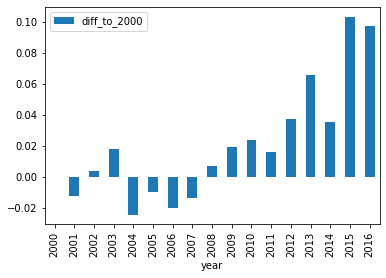

In [21]:
# Plot the percentage differences as bar plots
deaths_long.plot.bar(x='year', y='diff_to_2000')

## Teilaufgabe 6
Erstellen Sie eine Tabelle mit der Anzahl an Todesfällen, die mit Cancer in Verbindung stehen gruppiert nach Alter im Jahr 2016.

Wie bereits in vorherigen Aufgaben, werde ich mich auf Todesfälle in Deutschland beschränken.

In [39]:
# Create extra column with cause_name all in lower case so that I can reliably filter for cancer
deaths = deaths.withColumn('cause_name_lower', lower(col('cause_name')))
deaths.select('cause_name', 'cause_name_lower').show(5)

+----------+----------------+
|cause_name|cause_name_lower|
+----------+----------------+
|All Causes|      all causes|
|All Causes|      all causes|
|All Causes|      all causes|
|All Causes|      all causes|
|All Causes|      all causes|
+----------+----------------+
only showing top 5 rows



In [46]:
# Fitler for all deaths related to Cancer
deaths_cancer = deaths.filter(deaths['cause_name_lower'].contains('cancer')) \
    .filter(deaths['country'] == 'DEU')
print('Row count after filtering:', deaths_cancer.count())

# Group by age_group and and sum over deaths_2016
deaths_cancer = deaths_cancer.groupBy('age_group') \
    .sum('deaths_2016') \
    .withColumnRenamed('sum(deaths_2016)', 'sum_deaths_2016') \
    .orderBy('sum_deaths_2016', ascending=False)
deaths_cancer.show()

Row count after filtering: 500
+----------+-------------------+
| age_group|    sum_deaths_2016|
+----------+-------------------+
| AGE85-100| 37360.349177360535|
|  AGE75-79|  36791.70424938202|
|  AGE80-84| 32150.361338615417|
|  AGE70-74|  30743.27100276947|
|  AGE65-69| 21515.800642967224|
|  AGE60-64| 20715.345891952515|
|  AGE55-59| 14360.072834014893|
|  AGE50-54|  8985.578726768494|
|  AGE45-49| 4041.2642817497253|
|  AGE40-44| 1511.1719765663147|
|  AGE35-39|  712.9280898272991|
|  AGE30-34|  404.8013355731964|
|  AGE25-29| 189.77633187174797|
|  AGE20-24|  85.14372700452805|
|  AGE15-19| 53.055536691099405|
|    AGE5-9| 50.072960417717695|
|  AGE10-14|  33.33703737705946|
|    AGE1-4| 23.823335766792297|
|MONTHS1-11|  0.766697108745575|
|  DAYS0-28|0.16313045471906662|
+----------+-------------------+



In [22]:
# NEVER FORGET to stop the session
#spark.stop()